In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
% matplotlib inline

Aggregate bad words to list

In [2]:
folder = r'Data of bad words'
paths = os.listdir(folder)
list_of_bad_words = []
chars_to_remove = '\n\xa0'
for path in paths:
    curr_path = os.path.join(folder, path)
    with open(curr_path, 'r') as input_file:
        raw_list_of_words = input_file.readlines()
        list_of_bad_words.extend([x.strip(chars_to_remove)
                              for x in raw_list_of_words])
list_of_bad_words = list(set(list_of_bad_words))

Import database of labeld chats

In [5]:
file_path = r'formspring_data.csv.zip'
raw_data = pd.read_csv(file_path, sep='\t')

In [6]:
for ind in range(1,4):
    col = 'severity'+str(ind)
    raw_data[col].loc[raw_data[col] == 'None'] = 0
    raw_data[col].loc[raw_data[col] == 'n/a0'] = 0
    raw_data[col].loc[raw_data[col] == 'n/a'] = 0
    raw_data[col].loc[raw_data[col] == 'o'] = 0
    raw_data[col].loc[raw_data[col] == '0`'] = 0
    raw_data[col].loc[raw_data[col] == '`0'] = 0
    raw_data[col].loc[raw_data[col] == 'N/a'] = 0

Parse database into dataframe

In [7]:
posts, bully_bool, bully_num = [], [], []
for ind, row in raw_data.iterrows():
    post = row['post'].lstrip('Q: ').replace('<br>A: ','').replace(' ','_')
    posts.append(post)
    severity = [int(row['severity1']), 
                int(row['severity2']), 
                int(row['severity3'])]
    bully_bool.append(severity.count(0) <= 1)
    if bully_bool[ind]:
        bully_num.append(sum(severity) 
                         / (3 - severity.count(0)))
    else:
        bully_num.append(0)

data = pd.DataFrame({'post': posts, 
                     'is_bully': bully_bool,
                     'bully_severity': bully_num})
data.to_csv('parsed_data.csv')

Explore bully comments

In [9]:
word_dict = {}
for ind, row in data.loc[data.loc[:, 'is_bully'] == True, 'post'].iteritems():
    for word in row.split():
        if word.lower() not in word_dict:
            word_dict[word.lower()] = 1
        else:
            word_dict[word.lower()] += 1
sorted(word_dict.items(), key=lambda x: x[1], reverse=True)

[('do_you_have_any_memories_you&#039;d_like_to_forget?actually_i_do!!!_just_my_whole_experience_with_this_fake_a$$_friend!!</3',
  1),
 ('fuck_justin_bieber._he&#039;s_a_fucking_fagum_excuse_yuh?_he_is_not!!_ur_a_fuckin_idiot!_kay?_good',
  1),
 ('hahah._funny_how_u_defend_that_beiber_kid.&amp;_its_also_funny_how_u_stalked_my_whole_twitter!_nice_goin!_bitch!',
  1),
 ('hey._why_you_such_a_bitch?why_thank_yuh!', 1),
 ('how_old_are_u_?_and_how_do_you_know_michael?who_the_hell_are_yuh!!!_and_who_tha_fuck_is_michael!?',
  1),
 ('what_was_your_favorite_toy_to_play_with_as_a_child?now_how_the_fuck_am_i_suppose_to_remember_that?_weirdo!_maybe_it_was_ur_moms_dick?_lol!',
  1),
 ('who_decided_to_take_a_shit_on_your_face?im_not_quite_sure!_ill_tell_ya_when_i_find_out!_i_promise(:',
  1),
 ('why_do_u_follow_the_bandwagon?_formspring._twitter._what&#039;s_next_gay_justin_beiber.well_im_not_following_anything_and_really_bandwagon?!?!_soo_oldd!!_its_more_like_trend_these_days!_justin_bieber*_idiot!_

Data to train and test

In [10]:
X = data.loc[:, 'post']
y = data.loc[:, 'is_bully']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3)

In [11]:
def plot_roc_curve(y_true, prob):
    fpr, tpr, th = roc_curve(y_true, prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [37]:
class HeuristicClassifier(object):
    def __init__(self, list_of_words):
        self.list_of_bad_words = list_of_words
        self.prob = []
        self.prob_to_bully = []
    
    def fit(self, X, y):
        sum_words = []
        for ind, row in enumerate(X):
            sentence = row.split('_')
            sum_words.append(sum([word.lower() in self.list_of_bad_words 
                                  for word in sentence]))
            self.prob.append(sum_words[ind] / len(sentence))
        _, _, th = roc_curve(y, self.prob)
        self.thershold = th[-2]
        
    def predict(self, X):
        self.prob_to_bully = []
        if isinstance(X, str) is True:
            X = [X]
        sum_words = []
        for ind, row in enumerate(X):
            sentence = row.split('_')
            sum_words.append(sum([word.lower() in self.list_of_bad_words 
                                  for word in sentence]))
            self.prob_to_bully.append(sum_words[ind] / len(sentence))
            y_pred = [prob > self.thershold for prob in self.prob_to_bully]
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        print('log loss: %s' % log_loss(y, y_pred))
        print('accuracy: %s' % accuracy_score(y, y_pred))

log loss: 5.21876934892
accuracy: 0.848903966597


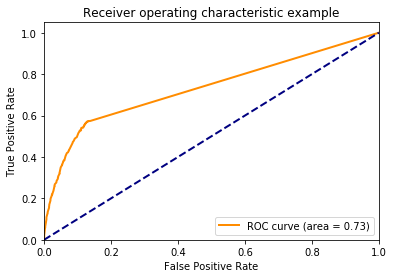

In [38]:
hc = HeuristicClassifier(list_of_bad_words)
hc.fit(X_train, y_train)
hc.score(X_test, y_test)
plot_roc_curve(y_train, hc.prob)

Pickle model

In [14]:
model_file_path = 'model.pickle'
with open(model_file_path, 'wb') as output_file:
    pickle.dump(hc, output_file)

Testing opening pickle

In [15]:
model_file_path = 'model.pickle'
with open(model_file_path, 'rb') as input_file:
    clf = pickle.load(input_file)
    
clf.predict('fuck')

[True]

Dill model

In [42]:
import dill
model_file_path = 'model.pickle'
with open(model_file_path, 'wb') as output_file:
    dill.dump(hc, output_file)